In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import zipfile
import requests
import io
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#np.savez('/content/gdrive/MyDrive/Data/Eurosat.npz', name1=X_train, name2=y_train, name3=X_test, name4=y_test)

In [5]:
data = np.load('/content/gdrive/MyDrive/Data/Eurosat.npz')

In [6]:
X_train = data['name1']
y_train = data['name2']
X_test = data['name3']
y_test = data['name4']

In [ ]:
input_shape = X_train.shape[1:]

**MODEL**

In [ ]:
model_file = '/content/gdrive/MyDrive/Models/VGG16.pt'
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 15, restore_best_weights = True)

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.1, patience = 5)

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file, monitor = 'val_loss',save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [ ]:
VGG = vgg16.VGG16(include_top=False,
            input_shape = input_shape)

In [ ]:
VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
len(VGG.trainable_weights)

26

In [ ]:
for layer in VGG.layers:
  layer.trainable = False

In [ ]:
len(VGG.trainable_weights)

0

In [ ]:
for layer in VGG.layers[7:]:
  layer.trainable = True

In [ ]:
len(VGG.trainable_weights)

18

In [ ]:
M = Sequential()

M.add(VGG)

M.add(Flatten())
M.add(Dropout(0.5))
M.add(Dense(512, activation='relu'))
M.add(Dense(10, activation='softmax'))

M.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 15,768,906
Trainable params: 15,508,746
Non-trainable params: 260,160
_________________________________________________________________


In [ ]:
M.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr = 1e-4),
              metrics=['accuracy'])

In [ ]:
batch_size =64
epochs = 100

In [ ]:
history = M.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = callback_list,
                    validation_data=(X_test, y_test))

Epoch 1/100
211/211 [==============================] - 53s 88ms/step - loss: 1.5183 - accuracy: 0.4544 - val_loss: 0.6559 - val_accuracy: 0.7736
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/VGG16.pt/assets
Epoch 2/100
211/211 [==============================] - 16s 78ms/step - loss: 0.5330 - accuracy: 0.8299 - val_loss: 0.4509 - val_accuracy: 0.8431
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/VGG16.pt/assets
Epoch 3/100
211/211 [==============================] - 16s 78ms/step - loss: 0.3636 - accuracy: 0.8867 - val_loss: 0.3111 - val_accuracy: 0.8985
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/VGG16.pt/assets
Epoch 4/100
211/211 [==============================] - 17s 78ms/step - loss: 0.2666 - accuracy: 0.9193 - val_loss: 0.1791 - val_accuracy: 0.9384
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/VGG16.pt/assets
Epoch 5/100
211/211 [==============================] - 17s 80ms/step - loss: 0.2113 - accura

In [7]:
M = keras.models.load_model('/content/gdrive/MyDrive/Models/VGG16.pt')

In [8]:
score = M.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17912067472934723
Test accuracy: 0.9383703470230103


In [22]:
P = np.argmax(M.predict(X_test), axis=-1)

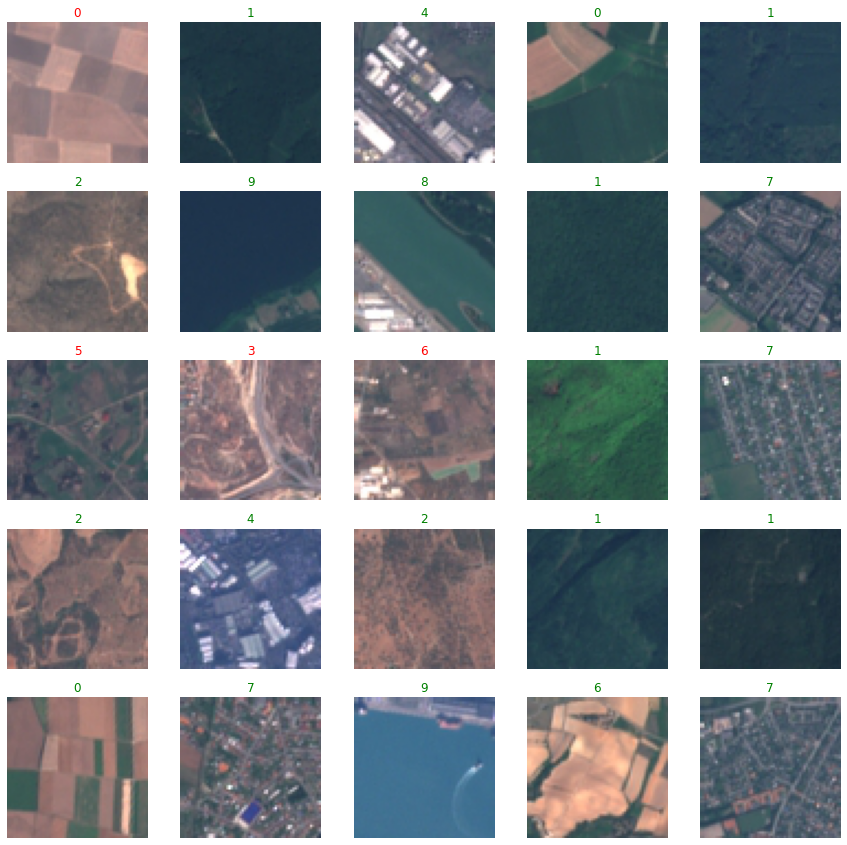

In [27]:
plt.figure(figsize=(15, 15))
for i in range(25):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(X_test[i])
  if np.argmax(y_test[i]) == P[i]:
    plt.title(np.argmax(y_test[i]), color="green")
  else:
    plt.title(np.argmax(y_test[i]), color="red")

  plt.axis("off")

plt.show()